# Basic Usage

1. install client and connect to the API

In [1]:
#%pip install ..
%pip install stability-sdk
!pip3 install torchvision

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 48 kB 445 kB/s eta 0:00:01
  Using cached grpcio-tools-1.48.1.tar.gz (2.2 MB)
  Using cached protobuf-3.19.5-py2.py3-none-any.whl (162 kB)
  Using cached grpcio-1.48.1.tar.gz (22.0 MB)
  Created wheel for grpcio: filename=grpcio-1.48.1-cp39-cp39-macosx_10_10_universal2.whl size=7861482 sha256=bd03da026132842aa26d77bd36531700a6a1656b4219c9199064fc7cd423b13f
  Stored in directory: /Users/subhamk/Library/Caches/pip/wheels/23/5b/89/888c2b1c7a384064e27dc02d88135132b43afa9e89ebf09862
  Created wheel for grpcio-tools: filename=grpcio_tools-1.48.1-cp39-cp39-macosx_10_10_universal2.whl size=4021174 sha256=222417014e4be94dd5297d4b726d64a60fce6cab1d03ed3585e82354121d69b1
  Stored in directory: /Users/subhamk/Library/Caches/pip/wheels/79/7a/c4/5235982860c95a54e3223b3f66198751322322d1ec118f16e7
Successfully built grpcio grpcio-tools
  Consider adding this directory to PATH or, if yo

In [8]:
import getpass, os

# NB: host url is not prepended with \"https\" nor does it have a trailing slash.
os.environ['STABILITY_HOST'] = 'grpc.stability.ai:443'

# To get your API key, visit https://beta.dreamstudio.ai/membership
os.environ['STABILITY_KEY'] = getpass.getpass('Enter your API Key')

In [9]:
import io
import os
import warnings

from IPython.display import display
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation


stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], 
    verbose=True,
)

2. Submit a request to generate a single image from a text prompt

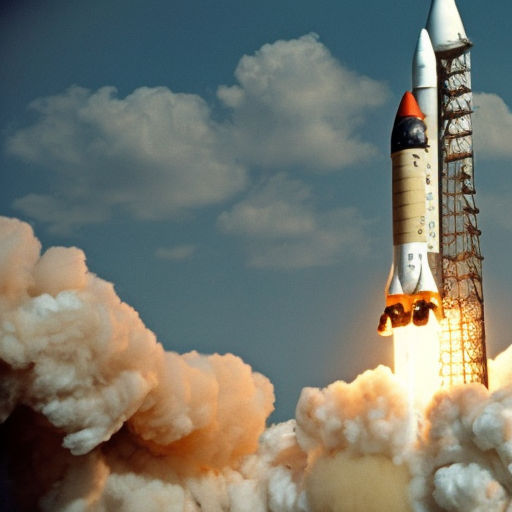

In [12]:
# the object returned is a python generator
answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=341567, # if provided, specifying a random seed makes results deterministic
    steps=200, # defaults to 30 if not specified
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img = Image.open(io.BytesIO(artifact.binary))
            display(img)

# Intermediate usage

3. (new!) An "init" image can be provided for text-driven image modification. To demonstrate, we can convert the image we just generated to a colored pencil sketch

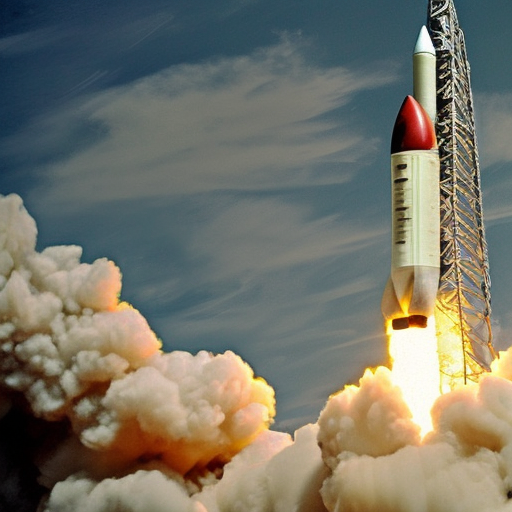

In [13]:
answers = stability_api.generate(
    prompt="childrens crayon drawing of a rocket launch",
    init_image=img,
    seed=54321, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=0.6, # this controls the "strength" of the prompt relative to the init image
)

# iterating over the generator produces the api response
for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img2 = Image.open(io.BytesIO(artifact.binary))
            display(img2)

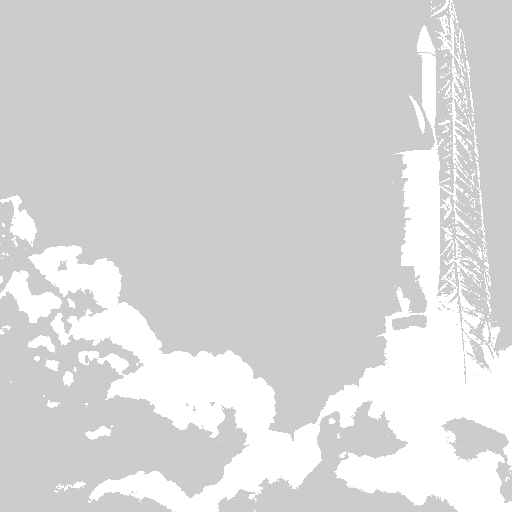

In [14]:
# we can make a rough mask by thresholding the grayscaled image

import numpy as np

img2_grayscale = img2.convert('L')
img2_a = np.array(img2_grayscale)

mask = np.array(img2_grayscale)
mask[img2_a<150] = 0  # this is the area that will get painted, will show up black below
mask[img2_a>=150] = 1 # this is the protected area, will show up white below

strength = .2  # this controls the "strength" of the prompt relative to the init image

d = int(255 * (1-strength))
mask *= 255-d # convert from range [0,1] to [0,255]
mask += d

mask = Image.fromarray(mask)
mask

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.3 MB 630 kB/s eta 0:00:01
  Using cached requests-2.28.2-py3-none-any.whl (62 kB)
  Using cached urllib3-1.26.14-py2.py3-none-any.whl (140 kB)
  Using cached charset_normalizer-3.0.1-cp39-cp39-macosx_11_0_arm64.whl (122 kB)
  Using cached certifi-2022.12.7-py3-none-any.whl (155 kB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


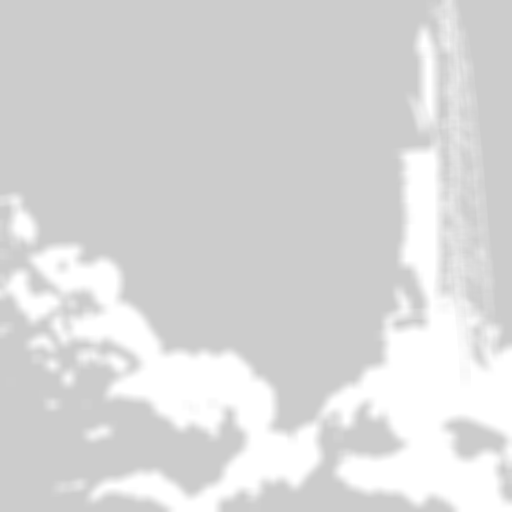

In [16]:
# fuzzing the mask edges generally improves synthesis results
from torchvision.transforms import GaussianBlur

blur = GaussianBlur(11,20)
mask = blur(mask)
mask

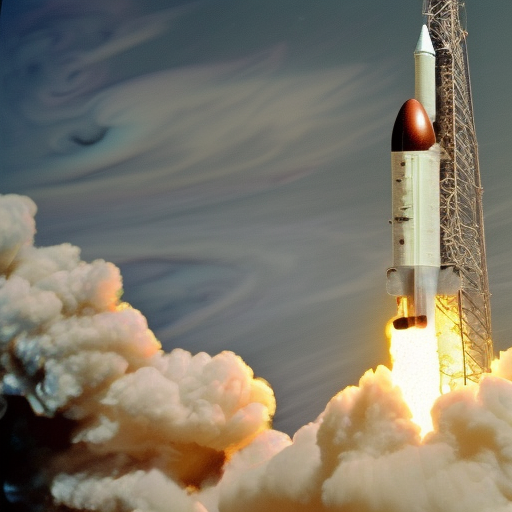

In [17]:
# now, let's send our drawing into space
answers = stability_api.generate(
    prompt="beautiful galaxies and stars in hubble telescope deep field",
    init_image=img2,
    mask_image=mask,
    seed=12345, # if we're passing in an image generated by SD, you may get better results by providing a different seed value than was used to generate the image
    start_schedule=1,
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img3 = Image.open(io.BytesIO(artifact.binary))
            display(img3)

GUIDANCE: FAST-BLUE:


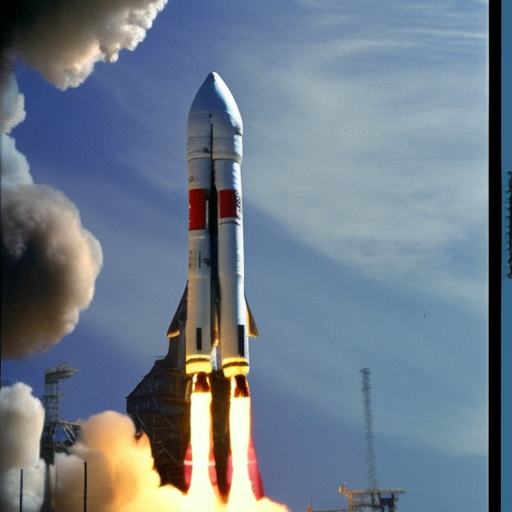

GUIDANCE: SLOWER:


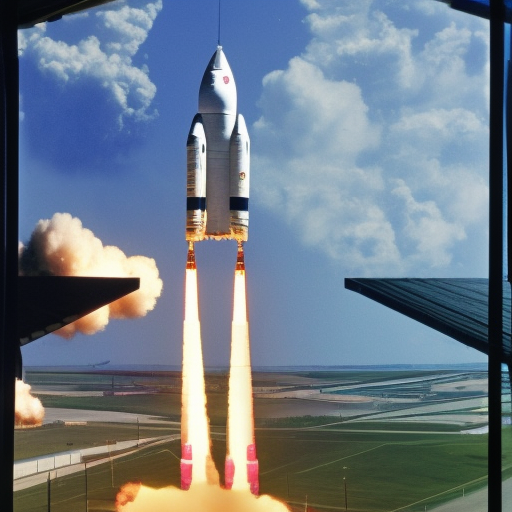

In [18]:
# we can improve our image result by introducing clip guidance into the request. this takes longer (and costs more compute) but often yields better results.
# clip guidance is built with several presets optimized for speed or quality, but clip can be controlled more precisely with a variety of other params

answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567,  
    steps=35, # minimum of 35 steps recommended when using CLIP
    guidance_preset = generation.GUIDANCE_PRESET_FAST_BLUE
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img4 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: FAST-BLUE:')
            display(img4)

answers = stability_api.generate(
    prompt="houston, we are a 'go' for launch!",
    seed=34567, 
    steps=35, 
    guidance_preset = generation.GUIDANCE_PRESET_SLOWER
)

for resp in answers:
    for artifact in resp.artifacts:
        if artifact.finish_reason == generation.FILTER:
            warnings.warn(
                "Your request activated the API's safety filters and could not be processed."
                "Please modify the prompt and try again.")
        if artifact.type == generation.ARTIFACT_IMAGE:
            img5 = Image.open(io.BytesIO(artifact.binary))
            print('GUIDANCE: SLOWER:')
            display(img5)